In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from CallOption import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 512  # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 2 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([0.5] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4
lr = 1e-3

In [4]:
model.load_model("models/CallOption.pth")

In [5]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(15):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)


In [6]:
X_pred = X_pred[:500,:]

In [7]:
from scipy.stats import multivariate_normal as normal

In [8]:
X_preds1 = X_pred[:,:,0]

In [9]:
X_preds2 = X_pred[:,:,1]

In [10]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 0.5     # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test1 = calculate_option_prices(X_preds1, t_test[0], K, r, sigma, T, q)
Y_test2 = calculate_option_prices(X_preds2, t_test[0], K, r, sigma, T, q)
Y_test = Y_test1 + Y_test2

/tmp/ipykernel_211885/3175505270.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [11]:
errors = np.abs(Y_test - Y_pred[:500,:,0])
errors.mean(), errors.std()

(0.006868794274057435, 0.006445397536743081)

In [13]:
graph = model.iteration, model.training_loss

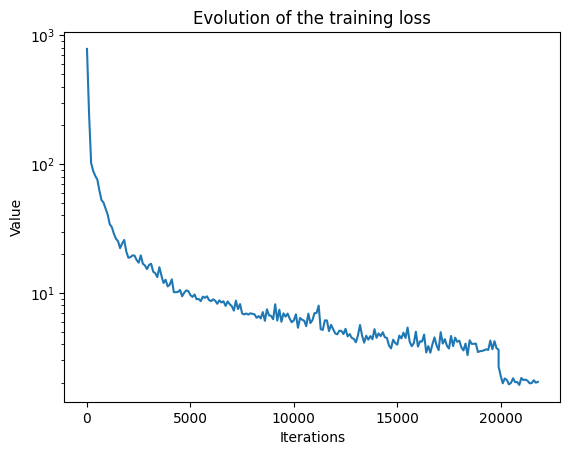

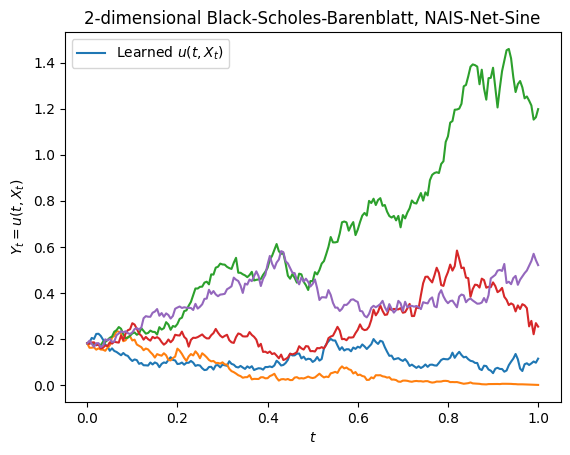

In [14]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 5
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

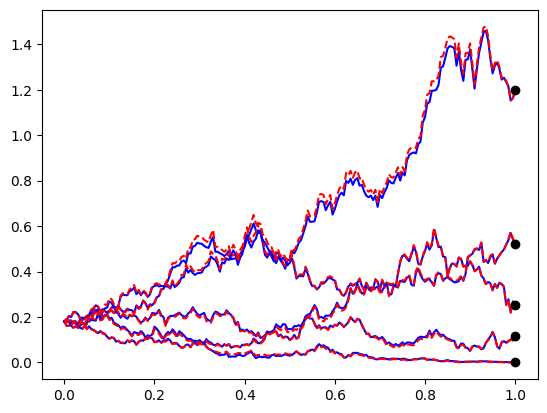

In [15]:
for i in range(samples):
    plt.plot(t_test[i], Y_pred[i], 'b', label='Learned $u(t,X_t)$')
    plt.plot(t_test[i], Y_test[i], 'r--', label='Exact $u(t,X_t)$')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko', label='$Y_T = u(T,X_T)$')

In [16]:
Y_pred.shape

(8192, 201, 1)

In [17]:
r = 0.05

In [19]:
Y_preds = Y_pred.reshape(8192,201)

In [21]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [22]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0)    
epe

array([0.18114194, 0.18133108, 0.1811757 , 0.18126372, 0.18121041,
       0.18126658, 0.18146378, 0.18151848, 0.18161787, 0.18156625,
       0.1813458 , 0.18142259, 0.18110022, 0.18142705, 0.18148527,
       0.18158923, 0.18147708, 0.18130389, 0.18132436, 0.181208  ,
       0.18132827, 0.18120392, 0.18112189, 0.18119623, 0.18114907,
       0.18088739, 0.18098424, 0.1810953 , 0.18130447, 0.18121819,
       0.18143493, 0.18157943, 0.18144344, 0.1809516 , 0.18112575,
       0.18119594, 0.1813876 , 0.18144096, 0.18150061, 0.18156394,
       0.18154399, 0.1817658 , 0.1820226 , 0.18179528, 0.18195337,
       0.18177642, 0.18207645, 0.18200868, 0.18224365, 0.18234673,
       0.18230315, 0.18221991, 0.18211602, 0.1824186 , 0.18240884,
       0.18245049, 0.1826209 , 0.18248117, 0.1824031 , 0.18225047,
       0.18204173, 0.18206483, 0.18204127, 0.18212095, 0.18233283,
       0.18204027, 0.18211941, 0.18205859, 0.18193775, 0.18197598,
       0.18207186, 0.18216848, 0.18204457, 0.18173797, 0.18156

In [23]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.52641587e-06,
       -1.34341280e-06, -8.11491191e-07, -1.49308471e-06, -1.43469515e-06,
       -3.39363214e-06, -2.73779460e-06, -3.17498234e-06, -4.16305011e-06,
       -7.28031046e-06, -9.70005749e-06, -9.95600931e-06, -1.11060390e-05,
       -1.69520081e-05, -1.76864287e-05, -1.83487900e-05, -1.71187094e-05,
       -1.82067834e-05, -1.90511837e-05, -2.44303483e-05, -2.96202616e-05,
       -3.19782266e-05, -

In [24]:
s=1.0 # spot price
k=1.0 # strike price
r=0.05 # risk-free rate
sigma=0.4 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [25]:
call 

0.18022951450216668

In [26]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

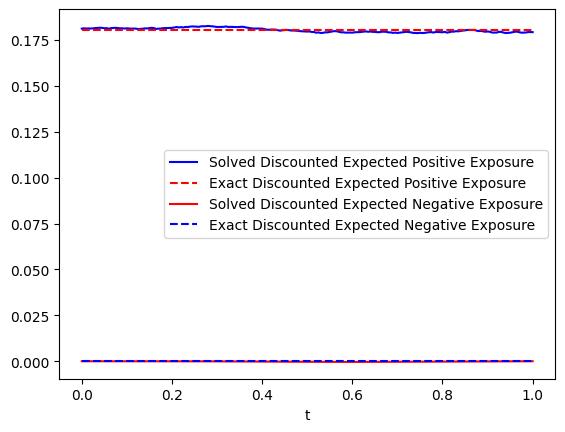

In [27]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [37]:
model.save_model("models/CallOption.pth")